C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/50


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Batch 1/387 ━━━━━━━━━━━━━━━━━━━━ 10:23:18
Accuracy: 0.6511 - Precision: 0.0389 - Recall: 0.7928 - Specificity: 0.6486 - F1: 0.0742 - Loss: 1.5864

Batch 2/387 ━━━━━━━━━━━━━━━━━━━━ 10:25:17
Accuracy: 0.7611 - Precision: 0.0750 - Recall: 0.8652 - Specificity: 0.7593 - F1: 0.1363 - Loss: 1.4791

Batch 3/387 ━━━━━━━━━━━━━━━━━━━━ 10:27:26
Accuracy: 0.8369 - Precision: 0.2427 - Recall: 0.7513 - Specificity: 0.8378 - F1: 0.2740 - Loss: 1.4046

Batch 4/387 ━━━━━━━━━━━━━━━━━━━━ 10:29:10
Accuracy: 0.8678 - Precision: 0.2587 - Recall: 0.7635 - Specificity: 0.8693 - F1: 0.3163 - Loss: 1.3447

Batch 5/387 ━━━━━━━━━━━━━━━━━━━━ 10:31:09
Accuracy: 0.8904 - Precision: 0.2476 - Recall: 0.8108 - Specificity: 0.8915 - F1: 0.3207 - Loss: 1.3105

Batch 6/387 ━━━━━━━━━━━━━━━━━━━━ 10:32:45
Accuracy: 0.9070 - Precision: 0.2567 - Recall: 0.8267 - Specificity: 0.9080 - F1: 0.3428 - Loss: 1.2820

Batch 7/387 ━━━━━━━━━━━━━━━━━━━━ 10:34:34
Accuracy: 0.9193 - Precision: 0.3556 - Recall: 0.7869 - Specificity: 0.9211 

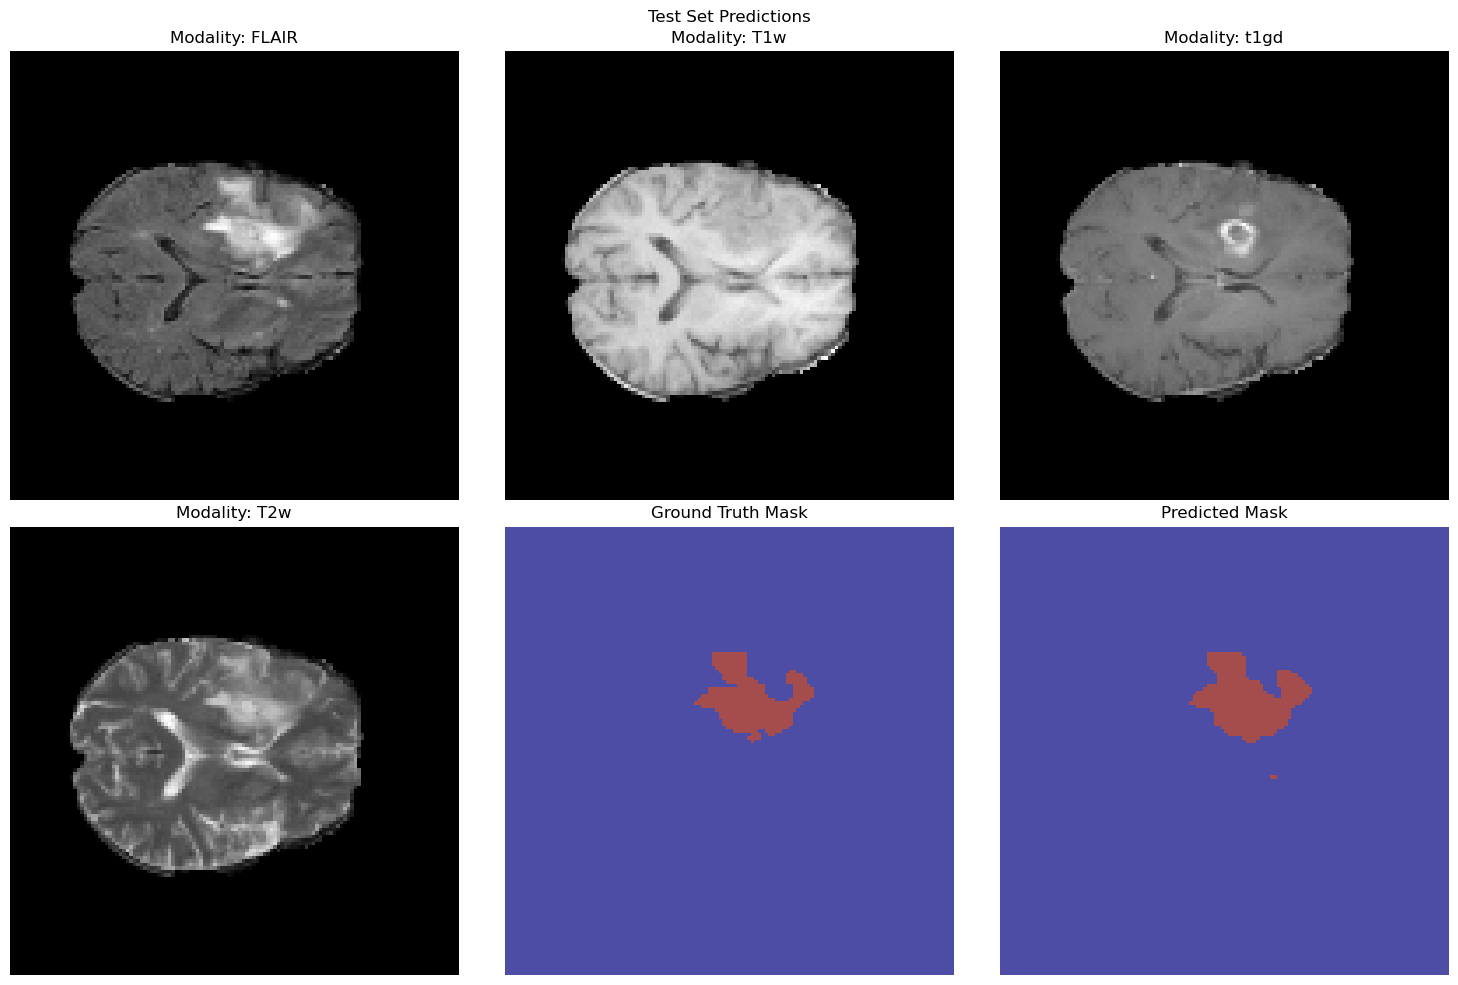

In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.ndimage import zoom, rotate
import random

# Paths to the dataset
#image_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\3D\Task01_BrainTumour\imagesTr'
#label_dir = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\ImageSegmentation\3D\Task01_BrainTumour\labelsTr'
image_dir = r'F:\Data\3D\Task01_BrainTumour\imagesTr'
label_dir = r'F:\Data\3D\Task01_BrainTumour\labelsTr'

# Parameters
batch_size = 1  # Reduced batch size to minimize memory load
dim = (128, 128, 128)  # Target dimensions for resizing
epochs = 50
modalities = ["FLAIR", "T1w", "t1gd", "T2w"]

# Load filenames and split into training and testing sets
image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Data Generator Class with Data Augmentation
class NiftiDataset(Sequence):
    def __init__(self, image_files, label_files, image_dir, label_dir, batch_size=2, dim=(128, 128, 128), shuffle=True, augment=False):
        self.image_files = image_files
        self.label_files = label_files
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Pre-allocate arrays for images and masks
        batch_images = np.zeros((self.batch_size, *self.dim, 4), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, *self.dim, 1), dtype=np.float32)

        for i, idx in enumerate(batch_indexes):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            mask_path = os.path.join(self.label_dir, self.label_files[idx])

            img = nib.load(img_path).get_fdata()  # Load 4D data with modalities as channels
            mask = nib.load(mask_path).get_fdata()

            img_resized = self.preprocess_image(img)
            mask_resized = self.preprocess_mask(mask)

            if self.augment:
                img_resized, mask_resized = self.augment_data(img_resized, mask_resized)

            batch_images[i] = img_resized
            batch_masks[i] = mask_resized[..., np.newaxis]  # Add channel dimension

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def preprocess_image(self, img):
        img = (img - np.mean(img, axis=(0, 1, 2))) / (np.std(img, axis=(0, 1, 2)) + 1e-7)  # Normalize per modality
        zoom_factors = [self.dim[i] / img.shape[i] for i in range(3)] + [1]  # Keep channels dimension unchanged
        img_resized = zoom(img, zoom_factors, order=1)
        return img_resized

    def preprocess_mask(self, mask):
        # Binarize the mask: Convert all non-zero labels to 1
        mask = np.where(mask > 0, 1, 0)
        zoom_factors = [self.dim[i] / mask.shape[i] for i in range(3)]
        mask_resized = zoom(mask, zoom_factors, order=0)  # Use nearest-neighbor for binary masks
        return mask_resized

    def augment_data(self, image, mask):
        # Randomly apply data augmentation
        # Flip
        if random.random() < 0.5:
            axis = random.choice([0, 1, 2])
            image = np.flip(image, axis=axis)
            mask = np.flip(mask, axis=axis)
        # Rotation
        if random.random() < 0.5:
            angle = random.uniform(-10, 10)
            axes = random.choice([(0, 1), (0, 2), (1, 2)])
            image = rotate(image, angle=angle, axes=axes, reshape=False, order=1)
            mask = rotate(mask, angle=angle, axes=axes, reshape=False, order=0)
        # Add more augmentations if needed
        return image, mask

# Define custom loss functions
def dice_loss(y_true, y_pred):
    smooth = 1e-7  # Smoothing constant to prevent division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - dice_coeff

def combined_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# Define TensorFlow-based Custom Metrics with Clipping
def custom_precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    precision = tp / (tp + fp + 1e-7)
    precision = tf.clip_by_value(precision, 0, 1)  # Clip the precision to ensure it stays between 0 and 1
    return precision

def custom_recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    recall = tp / (tp + fn + 1e-7)
    recall = tf.clip_by_value(recall, 0, 1)  # Clip recall between 0 and 1
    return recall

def custom_f1(y_true, y_pred):
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    f1 = tf.clip_by_value(f1, 0, 1)  # Clip F1 score between 0 and 1
    return f1

def custom_specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    specificity = tn / (tn + fp + 1e-7)
    specificity = tf.clip_by_value(specificity, 0, 1)  # Clip specificity between 0 and 1
    return specificity

# Define convolutional block with residual connections
def conv_block(inputs, filters, kernel_size=(3, 3, 3), padding='same', activation='relu'):
    x = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Residual connection
    shortcut = tf.keras.layers.Conv3D(filters, kernel_size=(1, 1, 1), padding='same')(inputs)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation(activation)(x)
    return x

# Define 3D U-Net Model with Residual Connections
def unet_3d(input_shape=(128, 128, 128, 4)):  # Adjust input_shape for 4 modalities
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = tf.keras.layers.MaxPooling3D((2, 2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = tf.keras.layers.MaxPooling3D((2, 2, 2))(c3)

    c4 = conv_block(p3, 256)

    # Decoder
    u5 = tf.keras.layers.UpSampling3D((2, 2, 2))(c4)
    u5 = tf.keras.layers.Conv3D(128, (2, 2, 2), activation='relu', padding='same')(u5)
    merge5 = tf.keras.layers.concatenate([c3, u5], axis=4)
    c5 = conv_block(merge5, 128)

    u6 = tf.keras.layers.UpSampling3D((2, 2, 2))(c5)
    u6 = tf.keras.layers.Conv3D(64, (2, 2, 2), activation='relu', padding='same')(u6)
    merge6 = tf.keras.layers.concatenate([c2, u6], axis=4)
    c6 = conv_block(merge6, 64)

    u7 = tf.keras.layers.UpSampling3D((2, 2, 2))(c6)
    u7 = tf.keras.layers.Conv3D(32, (2, 2, 2), activation='relu', padding='same')(u7)
    merge7 = tf.keras.layers.concatenate([c1, u7], axis=4)
    c7 = conv_block(merge7, 32)

    outputs = tf.keras.layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Custom callback to print more metrics at each batch and epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches
        self.batch_counter = 1

    def on_epoch_begin(self, epoch, logs=None):
        self.batch_counter = 1  # Reset batch counter at the start of each epoch
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy', 0)
        loss = logs.get('loss', 0)
        precision = logs.get('custom_precision', 0)
        recall = logs.get('custom_recall', 0)
        f1 = logs.get('custom_f1', 0)
        specificity = logs.get('custom_specificity', 0)
        current_time = datetime.now().strftime("%H:%M:%S")
        print(f"Batch {self.batch_counter}/{self.total_batches} ━━━━━━━━━━━━━━━━━━━━ {current_time}")
        print(f"Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - Specificity: {specificity:.4f} - F1: {f1:.4f} - Loss: {loss:.4f}\n")
        self.batch_counter += 1

    def on_epoch_end(self, epoch, logs=None):
        print(f"End of Epoch {epoch+1}")

# Initialize Generators with Data Augmentation for Training
train_gen = NiftiDataset(train_images, train_labels, image_dir, label_dir, batch_size=batch_size, dim=dim, augment=True)
val_gen = NiftiDataset(val_images, val_labels, image_dir, label_dir, batch_size=batch_size, dim=dim, shuffle=False)

# Define Model and Compile with Combined Loss Function
model = unet_3d(input_shape=dim + (4,))  # Adjust input_shape to include 4 channels for modalities
model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy', custom_precision, custom_recall, custom_f1, custom_specificity])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize Metrics Callback
steps_per_epoch = len(train_gen)
metrics_callback = MetricsCallback(total_batches=steps_per_epoch)

# Train Model with Data Augmentation and Modified Loss Function
model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, metrics_callback], verbose=0)

# Visualization Function for Multi-Modal Data
def visualize_predictions(images, true_masks, pred_masks, title):
    slice_index = images.shape[2] // 2
    plt.figure(figsize=(15, 10))

    for i in range(4):  # Loop over modalities
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[0][:, :, slice_index, i], cmap='gray')
        plt.title(f'Modality: {modalities[i]}')
        plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(true_masks[0][:, :, slice_index].squeeze(), cmap='jet', alpha=0.7)
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(pred_masks[0][:, :, slice_index].squeeze(), cmap='jet', alpha=0.7)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize Predictions for Test Set
X_test_batch, y_test_batch = val_gen.__getitem__(0)  # Get first batch from validation set
y_test_pred_batch = model.predict(X_test_batch)
y_test_pred_batch_bin = (y_test_pred_batch > 0.5).astype(np.uint8)

visualize_predictions(X_test_batch, y_test_batch, y_test_pred_batch_bin, "Test Set Predictions")


Runtime: 151.39 hours!